# **Auto Infrastructure**
### Converting Whiteboard Diagrams to Azure Resource Manager Deployments

In [47]:
import cv2
from google_images_download import google_images_download
import matplotlib.pyplot as plt
import imutils
import numpy as np
import pytesseract
import glob
import turicreate as tc
import json

## **Scrape images for later training**

In [ ]:
def search_and_download_images(keywords, num_images=40):

    response = google_images_download.googleimagesdownload() 

    arguments = {
        "keywords": keywords,
        "limit": num_images,
        "print_urls": True,
        "prefix_keywords": 'azure',
        "suffix_keywords": 'icon',
        "format": 'png'
    }
    absolute_image_paths = response.download(arguments)

    with open('./image_urls', 'w+') as image_urls_file:
        for k, v in absolute_image_paths.items():
            image_urls_file.write(k)
            image_urls_file.write('=' * 80)
            image_urls_file.writelines(list(absolute_image_paths.values()).join('\n\r'))
            
    return absolute_image_paths

search_and_download_images('database,virtual machine,webapp,file storage')

## **Example transformations**

In [101]:
image = cv2.imread('./downloads/azure database icon/3. azure-documentdb-database.png')
orig = image.copy()
image = imutils.resize(image, height=500)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)
inverted_edged = cv2.bitwise_not(edged)

cv2.imshow('Base', image)
cv2.imshow("Inverted Edge", inverted_edged)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [2]:
def create_edge_path_image(img_path, verbose=False):
    if verbose:
        print(img_path)
    image = cv2.imread(img_path)
    image = imutils.resize(image, height=500)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, 75, 125)
    inverted_edged = cv2.bitwise_not(edged)
    
    edge_path = img_path[:-4] + '-edged.png'
    
    cv2.imwrite(edge_path, inverted_edged)
    

In [54]:
for png_path in glob.glob('./images/*.jpeg'):
    create_edge_path_image(png_path)
    
    
# [{'coordinates': {'height': 104, 'width': 110, 'x': 115, 'y': 216},
#   'label': 'ball'},

## **Combine box annotaions from Prodigy image.manual with real images**

In [32]:
tc_object_detect_images = []
tc_object_detect_annotations = []

with open('./annotations/2/wb2arm_images_2.jsonl') as annotations_file:
    for line in annotations_file:
        annotations = json.loads(line)
        if annotations['answer'] == 'accept':
            boxes = annotations['spans']
            
#             print(annotations)
            object_detection_boxes_out = []
            for box in boxes:

                points = box['points']
                top_left, bottom_left, bottom_right, top_right = points
                print(top_left, top_right, bottom_right, bottom_left)
                width = float(top_right[0] - top_left[0])
                height = float(bottom_left[1] - top_left[1])
                x_center = float(top_left[0] + (width / 2))
                y_center = float(top_left[1] + (height / 2))

                object_detection_boxes_out.append({
                    'label': box['label'],
                    'coordinates': {
                        'height': height,
                        'width': width,
                        'x': x_center,
                        'y': y_center
                    }
                })
                
            print(annotations['meta']['file'])
            tc_object_detect_images.append(annotations['meta']['file'])
            tc_object_detect_annotations.append(object_detection_boxes_out)
            
            
annotations_sf = tc.SFrame({'filename': tc_object_detect_images, 'annotations': tc_object_detect_annotations})

[86.3, 102.1] [665, 102.1] [665, 339.8] [86.3, 339.8]
20180723_024521307_iOS.jpg
[251.5, 45.2] [562.9, 45.2] [562.9, 297.8] [251.5, 297.8]
20180723_024512276_iOS.jpg
[38, 47] [355, 47] [355, 377] [38, 377]
20180723_021708849_iOS.jpg
[92, 73] [281, 73] [281, 311] [92, 311]
20180723_021702377_iOS.jpg
[392.5, 42.1] [599.7, 42.1] [599.7, 264.1] [392.5, 264.1]
[170.4, 155.7] [320.9, 155.7] [320.9, 341.9] [170.4, 341.9]
[41, 240.9] [119.9, 240.9] [119.9, 328.3] [41, 328.3]
20180723_024439726_iOS.jpg
[127.3, 131.5] [279.9, 131.5] [279.9, 349.3] [127.3, 349.3]
[335.6, 42.1] [436.6, 42.1] [436.6, 158.9] [335.6, 158.9]
[377.7, 216.7] [580.8, 216.7] [580.8, 447.2] [377.7, 447.2]
20180723_022618958_iOS.jpg
[293.6, 87.3] [460.8, 87.3] [460.8, 318.8] [293.6, 318.8]
20180723_024539975_iOS.jpg
[69, 108] [148, 108] [148, 198] [69, 198]
[105, 236] [247, 236] [247, 385] [105, 385]
[303, 265] [383, 265] [383, 362] [303, 362]
20180723_021705068_iOS.jpg
[233.6, 143.1] [473.5, 143.1] [473.5, 404] [233.6, 404

In [82]:
# Resizes images downloaded from ios camera

for path in glob.glob('./test-images/*'):
    image = cv2.imread(path)
    try:
        
        image = imutils.resize(image, height=500)

        filename = path.split('/')[-1]
        path = '/'.join(path.split('/')[:-2]) + '/test-images-resized/'
        print(path + filename)
        cv2.imwrite(path + filename, image)
    except:
        pass

./test-images-resized/file.jpeg


## **Construct Object Detection Data**

In [33]:
images = tc.image_analysis.load_images('./images/Whiteboard2arm-data-resized/', recursive=True)
images['filename'] = images['path'].apply(lambda s: s.split('/')[-1])

In [34]:
tc_object_detect_data = images.join(annotations_sf, on='filename')[['image', 'annotations']]
tc_object_detect_data

image,annotations
Height: 500 Width: 375,"[{'label':'SQL_DATABASE', ..."
Height: 500 Width: 375,"[{'label':'SQL_DATABASE', ..."
Height: 500 Width: 375,"[{'label':'SQL_DATABASE', ..."
Height: 500 Width: 375,"[{'label':'SQL_DATABASE', ..."
Height: 500 Width: 666,"[{'label':'SQL_DATABASE', ..."
Height: 500 Width: 666,"[{'label':'SQL_DATABASE', ..."
Height: 500 Width: 666,"[{'label':'SQL_DATABASE', ..."
Height: 500 Width: 666,"[{'label':'SQL_DATABASE', ..."
Height: 500 Width: 666,"[{'label':'SQL_DATABASE', ..."
Height: 500 Width: 666,"[{'label':'DOCUMENT_DATABASE', ..."


In [35]:
train_data, test_data = tc_object_detect_data.random_split(0.8)


In [36]:
train_data.explore()

Materializing SFrame...

Done.

## **Train Object Detection Model on Whiteboard drawings**

In [ ]:
# Create a model
model = tc.object_detector.create(train_data, verbose=True)

In [ ]:

# Save predictions to an SArray
predictions = model.predict(test_data)

# Evaluate the model and save the results into a dictionary
metrics = model.evaluate(test_data)

In [ ]:
predictions

In [43]:
test_data

image,annotations
Height: 500 Width: 375,"[{'label':'SQL_DATABASE', ..."
Height: 500 Width: 666,"[{'label':'SQL_DATABASE', ..."
Height: 500 Width: 666,"[{'label':'DOCUMENT_DATABASE', ..."
Height: 500 Width: 666,"[{'label':'SQL_DATABASE', ..."
Height: 500 Width: 666,"[{'label':'SQL_DATABASE', ..."
Height: 500 Width: 666,"[{'label':'SQL_DATABASE', ..."
Height: 500 Width: 666,"[{'label': 'EVENT_HUB','coordinates': {'heig ..."
Height: 500 Width: 666,"[{'label': 'EVENT_HUB','coordinates': {'heig ..."
Height: 500 Width: 666,"[{'label': 'GENERIC_LABELED_SERVICE', ..."
Height: 500 Width: 666,"[{'label': 'GENERIC_LABELED_SERVICE', ..."


In [44]:
test = test_data.copy()
test['predictions'] = predictions
test['image_with_predictions'] = \
    tc.object_detector.util.draw_bounding_boxes(test['image'], test['predictions'])


Materializing SFrame...

Done.

In [45]:
test

image,annotations,predictions,image_with_predictions
Height: 500 Width: 375,"[{'label':'SQL_DATABASE', ...","[{'label':'SQL_DATABASE', 'type': ...",Height: 500 Width: 375
Height: 500 Width: 666,"[{'label':'SQL_DATABASE', ...","[{'label':'SQL_DATABASE', 'type': ...",Height: 500 Width: 666
Height: 500 Width: 666,"[{'label':'DOCUMENT_DATABASE', ...","[{'label':'DOCUMENT_DATABASE', ...",Height: 500 Width: 666
Height: 500 Width: 666,"[{'label':'SQL_DATABASE', ...","[{'label':'SQL_DATABASE', 'type': ...",Height: 500 Width: 666
Height: 500 Width: 666,"[{'label':'SQL_DATABASE', ...","[{'label':'SQL_DATABASE', 'type': ...",Height: 500 Width: 666
Height: 500 Width: 666,"[{'label':'SQL_DATABASE', ...","[{'label':'SQL_DATABASE', 'type': ...",Height: 500 Width: 666
Height: 500 Width: 666,"[{'label': 'EVENT_HUB','coordinates': {'heig ...",[],Height: 500 Width: 666
Height: 500 Width: 666,"[{'label': 'EVENT_HUB','coordinates': {'heig ...",[],Height: 500 Width: 666
Height: 500 Width: 666,"[{'label': 'GENERIC_LABELED_SERVICE', ...","[{'label': 'GENERIC_LABELED_SERVICE', 'type': ...",Height: 500 Width: 666
Height: 500 Width: 666,"[{'label': 'GENERIC_LABELED_SERVICE', ...","[{'label': 'GENERIC_LABELED_SERVICE', 'type': ...",Height: 500 Width: 666


In [48]:
test['image'].apply(lambda x: x)
test['image_with_predictions'].apply(lambda x: x)
test[['image', 'image_with_predictions']].explore()

Materializing SFrame...

Done.

In [53]:
test.save('predictions.sframe')

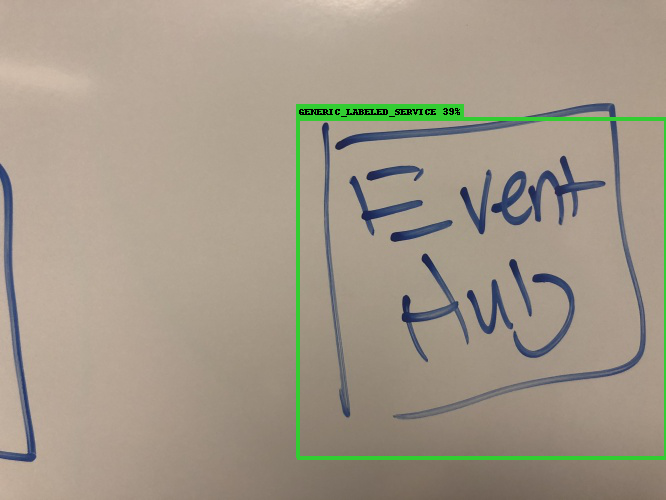

In [75]:
test['image_with_predictions'][8]._to_pil_image()

## **Let's look at a larger example**

### We basically want to stream data from an Event Hub (Kafka-like injestion) into Cosmos DB and process the Cosmos DB Change Feed with an Azure Function App

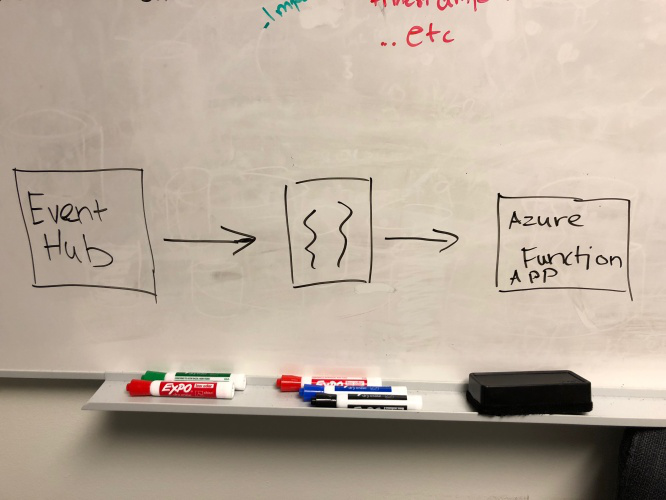

In [83]:
test_image = tc.image_analysis.load_images('./test-images-resized')
test_image['image'][0]._to_pil_image()

In [84]:
test_image_prediction = model.predict(test_image)

Predicting 1/1


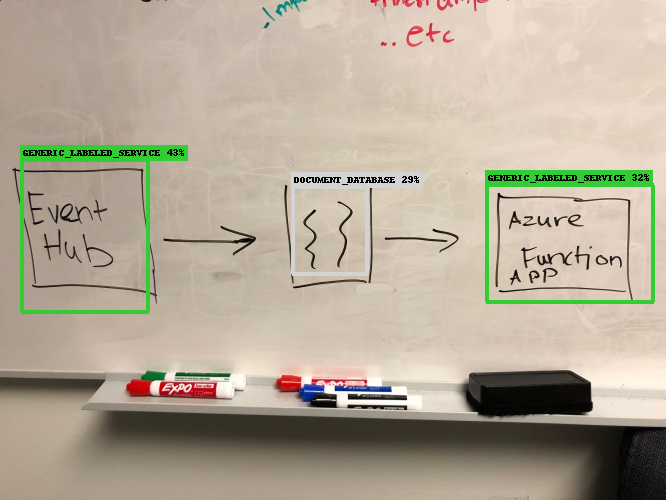

In [99]:
test_image['image_with_predictions'] = \
    tc.object_detector.util.draw_bounding_boxes(test_image['image'], test_image_prediction)

test_image['image_with_predictions'][0]._to_pil_image()

## **Future Work**
* Run OCR (pytesseract) inside the bounding boxes with GENERIC_LABELED_SERVICE label. 
* Analyze Arrows indicating data flow to help interpret how data will be processed (default to left - right)
* Map class labels to Azure Resource Manager templates.
* Expand to other clouds
